# Compare our values to Nirody et al. 2021
<br>
This notebook = inter-leg coordination <br>
  ... in Nirody this is:<br>

### Figure 4
### Figure S6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import colormaps as cm
import os
import glob
import gaitFunctions
from scipy import stats
import seaborn as sns

In [2]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/movement_disorder_paper_2023/videos_exemplaris/analyses_summaries/')
for f in sorted(glob.glob('*.xlsx')):
    print(f)

4Jan_combined_21Dec_11Dec_9Nov.xlsx
iw_11Dec23_exemplaris_inverted_combined.xlsx
iw_21Dec23_exemplaris_inverted_combined.xlsx
iw_9Nov23_exemplaris_inverted_combined.xlsx


In [3]:
# specify the data file
data_file = '4Jan_combined_21Dec_11Dec_9Nov.xlsx'

In [4]:
def swingTimingProbabilities(proportions, speeds, step_df, ref_leg, comp_leg, comp_type = 'swingswing'):
    
    if comp_type == 'swingswing':
        comps = ['UpTime','UpTime']
    elif comp_type == 'stanceswing':
        comps = ['DownTime','UpTime']
    elif comp_type == 'swingstance':
        comps = ['UpTime','DownTime']
    elif compt_type == 'stancestance':
        comps = ['DownTime','DownTime']
    else:
        comps = ['UpTime','UpTime']
    
    individuals = np.sort(np.unique(step_df['uniq_id'].values))
    for individual in individuals:
        individual_data = step_df[step_df['uniq_id']==individual]
        ref_leg_events = individual_data[individual_data['legID'] == ref_leg][comps[0]].values
        ref_leg_speeds = individual_data[individual_data['legID'] == ref_leg]['speed_during_step'].values
        ref_leg_bodylengths = individual_data[individual_data['legID'] == ref_leg]['average_tardigrade_length'].values
        comp_leg_events = individual_data[individual_data['legID'] == comp_leg][comps[1]].values
        for i, ref_event in enumerate(ref_leg_events[:-1]):
            next_ref_event = ref_leg_events[i+1]
            next_comp_idx = np.where(comp_leg_events>ref_event)[0]
            speed_during_step = ref_leg_speeds[i]
            length_during_step = ref_leg_bodylengths[i]
            if len(next_comp_idx) > 0:
                next_comp_event = comp_leg_events[next_comp_idx[0]]
                ref_cycle = next_ref_event-ref_event
                comp_event_offset = next_comp_event-ref_event
                comp_event_phase_proportion = comp_event_offset / ref_cycle
#                 print(ref_event, next_comp_event, next_ref_event, comp_event_phase_proportion) # testing
                if comp_event_offset <= ref_cycle:
                    proportions.append(comp_event_phase_proportion)
                    speeds.append(speed_during_step/length_during_step)
            
    return proportions, speeds

In [5]:
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

# colors
all_leg_color = '#00b6eb' # light blue
L2_L1_color =   '#e5330d' # red
L3_L2_color =   '#302382' # purple
R2_R1_color =   '#006f2a' # green
R3_R2_color =   '#ffd500' # yellow

# load data from data_file
step_df = pd.read_excel(data_file, sheet_name='step_timing', index_col=None)
print(step_df.columns)
step_df.head(3)

Index(['legID', 'DownTime', 'UpTime', 'stance', 'swing', 'gait', 'duty',
       'midSwingTime', 'L1_mid_swings', 'R1_mid_swings', 'L2_mid_swings',
       'R2_mid_swings', 'L3_mid_swings', 'R3_mid_swings', 'L4_mid_swings',
       'R4_mid_swings', 'anterior_swing_start', 'contralateral_swing_start',
       'speed_during_step', 'speed_during_step_scaled', 'distance_during_step',
       'distance_during_step_scaled', 'cruising_during_step',
       'average_tardigrade_area', 'average_tardigrade_length',
       'anterior_offsets', 'contralateral_offsets', 'metachronal_lag', 'clip',
       'treatment', 'individual', 'date', 'uniq_id'],
      dtype='object')


,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,average_tardigrade_area,average_tardigrade_length,anterior_offsets,contralateral_offsets,metachronal_lag,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,16019.862069,255.118156,NaN,0.667,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,16147.450000,254.255372,NaN,1.030,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,16140.948718,257.286118,NaN,0.879,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


# Nirody Figure 4

# 4A

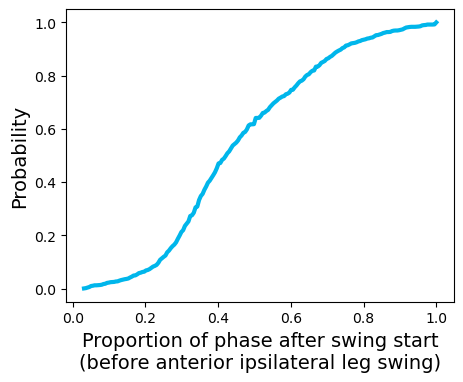

In [6]:
proportions = []
speeds = []
for leg in ipsi_offset_legs:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, ipsi_legs[leg])

fig,ax = plt.subplots(1,1,figsize=(5,3.8))
H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax.plot(X1[1:], F1, linewidth=3, color = all_leg_color, label='all legs')

# seaborn kernel density estimation
# ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, cumulative=True,
#                   stat='probability',line_kws={'linewidth':5},
#                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars
plt.xlabel('Proportion of phase after swing start\n(before anterior ipsilateral leg swing)',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()

## 4A, inset

L2 : 465 steps
L3 : 472 steps
R2 : 474 steps
R3 : 467 steps


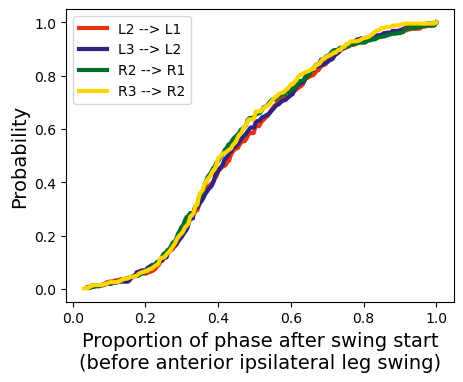

In [7]:
f,ax = plt.subplots(1,1,figsize=(5,3.8))
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]
ypos = 1

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, comp[0], comp[1])
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, linewidth=3, color = plot_cols[i], label=' --> '.join(comp))
    
#     ax = sns.histplot(proportions, ax=ax, binwidth=0.05, cumulative=True,
#                       stat='probability',line_kws={'linewidth':3}, kde=True,
#                       color=plot_cols[i], edgecolor='w', visible=False) # can set to false to hide bars
    
#     # klugey legend
#     plt.plot([0,0.08],[ypos,ypos],color=plot_cols[i],linewidth=3)
#     plt.text(0.1,ypos-0.01, ' --> '.join(comp),fontsize=12)
#     ypos -= 0.06
    
    print(comp[0], ':', len(proportions), 'steps')

plt.xlabel('Proportion of phase after swing start\n(before anterior ipsilateral leg swing)',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)    
ax.legend()
plt.show()

# 4B

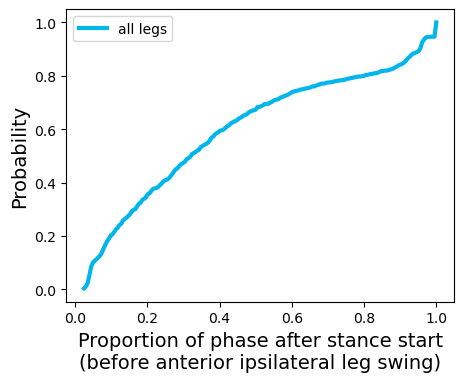

In [8]:
proportions = []
speeds = []
for leg in ipsi_offset_legs:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, ipsi_legs[leg], 'stanceswing')

fig,ax = plt.subplots(1,1,figsize=(5,3.8))

H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax.plot(X1[1:], F1, linewidth=3, color = all_leg_color, label='all legs')
# ax = sns.histplot(proportions, ax=ax, binwidth=0.05, cumulative=True, kde=True,
#                   stat='probability',line_kws={'linewidth':5},
#                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars
plt.xlabel('Proportion of phase after stance start\n(before anterior ipsilateral leg swing)',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)   
ax.legend()
plt.show()

# 4B, inset

L2 : 407 steps
L3 : 425 steps
R2 : 410 steps
R3 : 420 steps


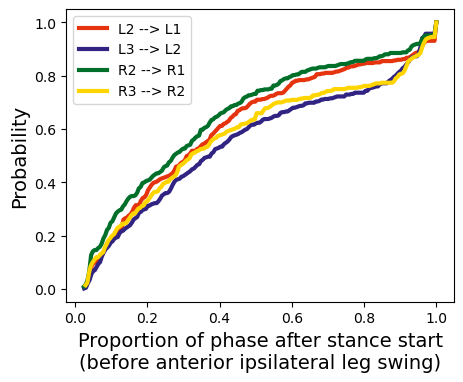

In [9]:
f,ax = plt.subplots(1,1,figsize=(5,3.8))
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]
ypos = 1

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, comp[0], comp[1], 'stanceswing')
  
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, linewidth=3, color = plot_cols[i], label=' --> '.join(comp))

#     ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, cumulative=True,
#                       stat='probability',line_kws={'linewidth':3}, legend=True,
#                       color=plot_cols[i], edgecolor='w', visible=False) # can set to false to hide bars
    
#     # klugey legend
#     plt.plot([0,0.08],[ypos,ypos],color=plot_cols[i],linewidth=3)
#     plt.text(0.1,ypos-0.01, ' --> '.join(comp),fontsize=12)
#     ypos -= 0.06
    
    print(comp[0], ':', len(proportions), 'steps')
ax.legend()
plt.xlabel('Proportion of phase after stance start\n(before anterior ipsilateral leg swing)',fontsize=14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)   
plt.show()

# 4B, but adjust x-axis to start just BEFORE stance

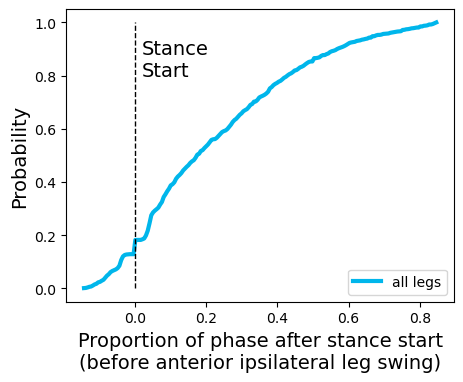

In [10]:
proportions = []
speeds = []
for leg in ipsi_offset_legs:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, ipsi_legs[leg], 'stanceswing')

fig,ax = plt.subplots(1,1,figsize=(5,3.8))

# offset x axis to just before stance start
threshold = 0.85
proportions = [x if x<=threshold else x-1 for x in proportions]

H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax.plot(X1[1:], F1, linewidth=3, color = all_leg_color, label='all legs')
# ax = sns.histplot(proportions, ax=ax, binwidth=0.05, cumulative=True, kde=True,
#                   stat='probability',line_kws={'linewidth':5},
#                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars
plt.xlabel('Proportion of phase after stance start\n(before anterior ipsilateral leg swing)',fontsize=14)
plt.plot([0,0],[0,1],'--k',linewidth=1)
plt.text(0.02,0.8,'Stance\nStart',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)   
ax.legend()
plt.show()

# 4C

1878 steps


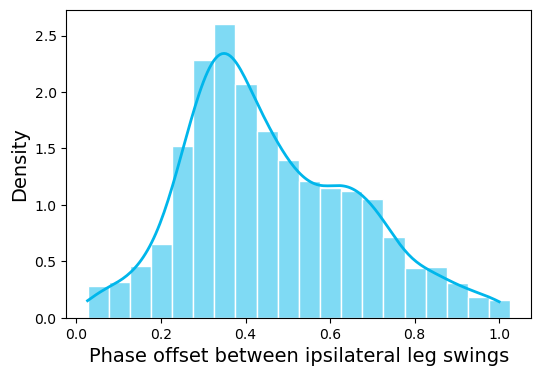

In [11]:
proportions = []
speeds = []
for leg in ipsi_offset_legs:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, ipsi_legs[leg])

fig,ax = plt.subplots(1,1,figsize=(6,4))
ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=all_leg_color, edgecolor='w', visible=True) # can set to False to hide bars
print(len(proportions), 'steps')
ax.yaxis.label.set_size(14)
ax.tick_params(axis='both', which='major', labelsize=10) 
ax.set_xlabel('Phase offset between ipsilateral leg swings', fontsize=14)
plt.show()

# 4C, inset

L2 : 465 steps
L3 : 472 steps
R2 : 474 steps
R3 : 467 steps


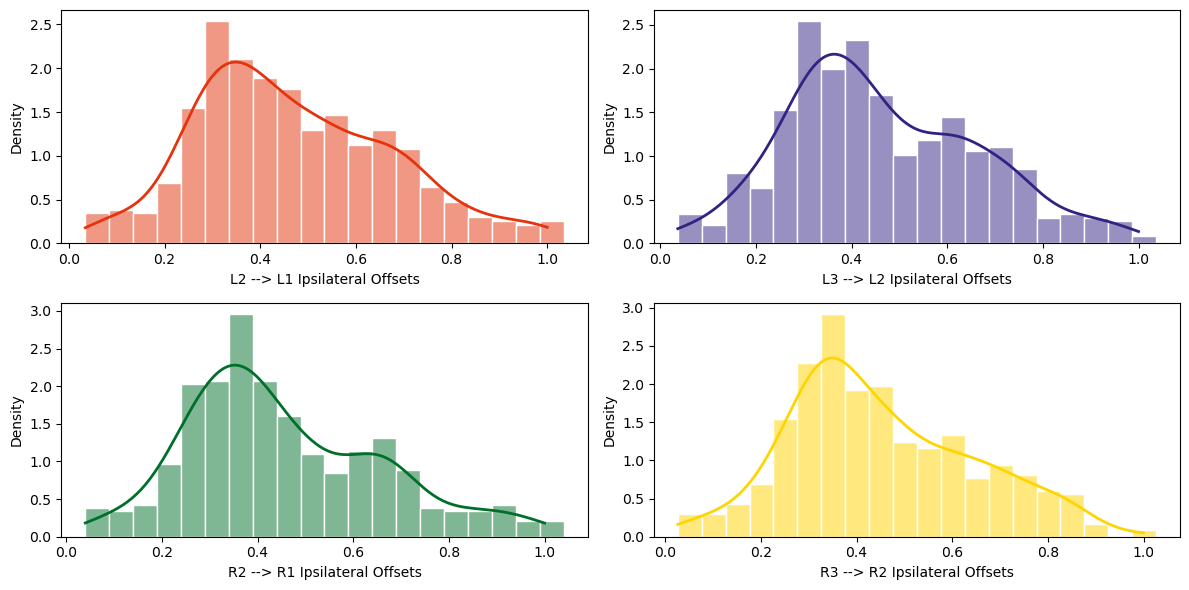

In [12]:
f,axes = plt.subplots(2,2,figsize=(12,6))
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]

for i, ax in enumerate(axes.flat):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg_comps[i][0], leg_comps[i][1])
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=plot_cols[i], edgecolor='w', visible=True) # can set to false to hide bars
    
    ax.set_xlabel(' --> '.join(leg_comps[i]) + ' Ipsilateral Offsets')
    
    print(leg_comps[i][0], ':', len(proportions), 'steps')

plt.tight_layout()
plt.show()

# Plot Speed vs. Ipsilateral Offsets

speed_boundaries I used in Speed and Step Kinematics = [0,0.225,0.35,1]

1878 1878
1816 1816


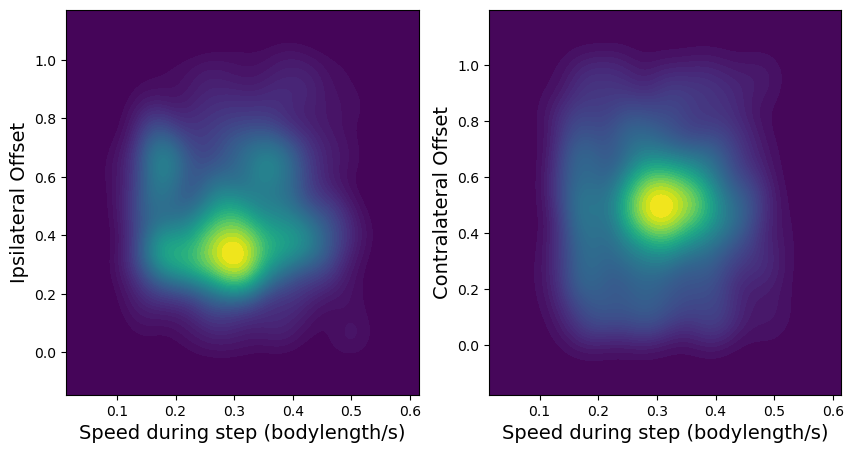

In [13]:
ipsi_proportions = []
ipsi_speeds = []
contra_proportions = []
contra_speeds = []
for leg in ipsi_offset_legs:
    ipsi_proportions, ipsi_speeds = swingTimingProbabilities(ipsi_proportions, ipsi_speeds, step_df, leg, ipsi_legs[leg])
for leg in ipsi_offset_legs:
    contra_proportions, contra_speeds = swingTimingProbabilities(contra_proportions, contra_speeds, step_df, leg, contra_legs[leg])

print(len(ipsi_proportions), len(ipsi_speeds))
print(len(contra_proportions), len(contra_speeds))
    
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))
ax1 = sns.kdeplot(ax=ax1, x=ipsi_speeds, y=ipsi_proportions, fill=True, cmap='viridis', thresh=0, levels=50)
ax2 = sns.kdeplot(ax=ax2, x=contra_speeds, y=contra_proportions, fill=True, cmap='viridis', thresh=0, levels=50)

ax1.set_xlabel('Speed during step (bodylength/s)', fontsize=14)
ax1.set_ylabel('Ipsilateral Offset', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=10)

ax2.set_xlabel('Speed during step (bodylength/s)', fontsize=14)
ax2.set_ylabel('Contralateral Offset', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=10)

# ax1.set_aspect('equal')
plt.show()

# Modes of tetrapod and tripod

In [16]:
num_cycles = 4
duty_factor =     2/3 # in fraction of gait cycle
anterior_offset = 1/2 # in fraction of gait cycle
opposite_offset = 1/2 # in fraction of gait cycle
legs = ['L3','L2','L1','R1','R2','R3']

def getLegTiming(leglist, duty_factor, anterior_offset, duty_factor):
    stance_start = {}
    stance_ends = {}
    swing_starts = {}
    swing_ends = {}
    for leg in leglist:
        if '3' in leg:
            stance_start[leg]

[0 1 2 3]


# 4D contralateral vs. ipsilateral

In [ ]:
# make an arrow as a marker

arrowhead_offset = 0.3
arrowhead_length = 0.4
arrowup_verts = [
   (arrowhead_offset, 0),  # left, bottom
   (arrowhead_offset, 1-arrowhead_length),  # left, top before arrow
   (0, 1-arrowhead_length), # left lower corner of arrow
   (0.5, 1), # top point of arrow
   (1, 1-arrowhead_length), # right lower corner of arrow
   (1-arrowhead_offset, 1-arrowhead_length),  # right, top before arrow
   (1-arrowhead_offset, 0.),  # right, bottom
   (0., 0),  # ignored
]

arrowup_verts = [(x[0]*2 - 1,x[1]*2-1) for x in arrowup_verts]
arrowdown_verts = [(x[0],-x[1]) for x in arrowup_verts]


arrow_codes = [
    mpath.Path.MOVETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.LINETO,
    mpath.Path.CLOSEPOLY,
]
arrowup   = mpath.Path(arrowup_verts, arrow_codes)
arrowdown = mpath.Path(arrowdown_verts, arrow_codes)

# some voodoo here
flipped = arrowdown.vertices[::-1, ...]
flipped[0] = [-0.4,1]

# cirle 
circle = mpath.Path.unit_circle()

cut_vertsup   = np.concatenate([circle.vertices, arrowup.vertices])
cut_vertsdown = np.concatenate([circle.vertices, flipped])

cut_codesup   = np.concatenate([circle.codes, arrowup.codes])
cut_codesdown = np.concatenate([circle.codes, arrowdown.codes])

cut_arrowup   = mpath.Path(cut_vertsup,   cut_codesup)
cut_arrowdown = mpath.Path(cut_vertsdown, cut_codesdown)

fig, ax = plt.subplots()
# patch = patches.PathPatch(path, facecolor='orange', lw=2)
# ax.add_patch(patch)
plt.plot(-0.5,0,marker=arrowup,markersize=15, color='g')
plt.plot(-0.5,1,marker=cut_arrowup,markersize=15, color='r')
plt.plot(0.5,0,marker=arrowdown,markersize=15, color='g')
plt.plot(0.5,1,marker=cut_arrowdown,markersize=15, color='b')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()

In [ ]:
# add gait style labels to axis
def addGaitStyleLabels(ax, with_text = True):
    combos, color_dict = gaitFunctions.get_gait_combo_colors('lateral')

    star = mpath.Path.unit_regular_star(5)
    circle = mpath.Path.unit_circle()
    cut_star = mpath.Path(
        vertices=np.concatenate([circle.vertices, star.vertices[::-1, ...]]),
        codes=np.concatenate([circle.codes, star.codes]))

    tet = color_dict['tetrapod_canonical']
    tri = color_dict['tripod_canonical']
    
    ybuff = 0.01

    # markers
    ax.plot(1/3,1/3,marker=arrowup,markersize=15,color=tet)
    ax.plot(1/3,2/3,marker=arrowdown,markersize=15,color=tet)
    ax.plot(2/3,1/3,marker=arrowup,markersize=15,color=tet)
    ax.plot(2/3,2/3,marker=arrowdown,markersize=15,color=tet)
    ax.plot(1/2,1/3,marker=cut_arrowup,markersize=15,color=tet)
    ax.plot(1/2,2/3,marker=cut_arrowdown,markersize=15,color=tet)
    ax.plot(1/2,1/2,marker=star,markersize=15,color=tri)

    if with_text:
        # text for tetrapod
        ax.text(0.05,1/3-ybuff,'Tetrapod',color=tet) # lower left tetrapod
        ax.text(0.05,2/3-ybuff,'Tetrapod',color=tet) # upper left tetrapod
#         ax.text(0.05,1/3-ybuff,'Tetrapod\nRear -> Front',color=tet) # lower left tetrapod
#         ax.text(0.05,2/3-ybuff,'Tetrapod\nFront -> Rear',color=tet) # upper left tetrapod
        #ax.text(0.75,1/3-ybuff,'Tetrapod',color=tet) # lower right tetrapod
        #ax.text(0.75,2/3-ybuff,'Tetrapod',color=tet) # upper right tetrapod

        # text for synchronous
        ax.text(0.1,0.85,'Synchronous',color=tet) # upper left synchronous
        ax.text(0.1,0.12,'Synchronous',color=tet) # lower left synchronous
        ax.text(0.67,0.85,'Synchronous',color=tet) # upper right synchronous
        ax.text(0.67,0.12,'Synchronous',color=tet) # lower right synchronous

        # rectangles and text for asynchronous
        rect1 = patches.Rectangle((0.37, 0.83), 0.29, 0.07, edgecolor='none', facecolor=tet) # upper tetrapod rectangle
        ax.text(0.38,0.85,'Asynchronous',color='w') # upper tetrapod rectangle
        rect2 = patches.Rectangle((0.37, 0.1), 0.29, 0.07, edgecolor='none', facecolor=tet) # lower tetrapod rectangle
        ax.text(0.38,0.12,'Asynchronous',color='w') # lower tetrapod rectangle
        ax.add_patch(rect1)
        ax.add_patch(rect2)

        # text for tripod
        ax.text(0.05,1/2-ybuff,'Tripod',color=tri) # Tripod
#         ax.text(0.38,0.55,'Synchronous',color=tri) # Synchronous tripod
    
    return ax

In [ ]:
ipsi_swing_offset_proportions = []
contra_swing_offset_proportions = []
speeds=[]

# code modified from swingTimingProbabilities function above
individuals = np.sort(np.unique(step_df['uniq_id'].values))
for ref_leg in ipsi_offset_legs:
    for individual in individuals:
        individual_data = step_df[step_df['uniq_id']==individual]
        ref_leg_swings = individual_data[individual_data['legID'] == ref_leg]['UpTime'].values
        anterior_leg_swings = individual_data[individual_data['legID'] == ipsi_legs[ref_leg]]['UpTime'].values
        opposite_leg_swings = individual_data[individual_data['legID'] == contra_legs[ref_leg]]['UpTime'].values
        
        ref_leg_speeds = individual_data[individual_data['legID'] == ref_leg]['speed_during_step'].values
        ref_leg_bodylengths = individual_data[individual_data['legID'] == ref_leg]['average_tardigrade_length'].values
        
        for i, ref_swing in enumerate(ref_leg_swings[:-1]):
            next_ref_swing = ref_leg_swings[i+1]
            next_ant_idx = np.where(anterior_leg_swings>ref_swing)[0]
            next_opp_idx = np.where(opposite_leg_swings>ref_swing)[0]
            
            # add speed
            speed_during_step = ref_leg_speeds[i]
            length_during_step = ref_leg_bodylengths[i]
            
            if len(next_ant_idx) > 0 and len(next_opp_idx) > 0:
                next_ant_swing = anterior_leg_swings[next_ant_idx[0]]
                next_opp_swing = opposite_leg_swings[next_opp_idx[0]]
                
                ref_cycle = next_ref_swing-ref_swing
                
                ant_swing_offset = next_ant_swing-ref_swing
                opp_swing_offset = next_opp_swing-ref_swing
                
                ant_swing_phase_proportion = ant_swing_offset / ref_cycle
                opp_swing_phase_proportion = opp_swing_offset / ref_cycle
                
                if ant_swing_phase_proportion <= ref_cycle and opp_swing_phase_proportion < ref_cycle:
                    ipsi_swing_offset_proportions.append(ant_swing_phase_proportion) 
                    contra_swing_offset_proportions.append(opp_swing_phase_proportion)
                    speeds.append(speed_during_step/length_during_step)

ipsi_phase = np.array(ipsi_swing_offset_proportions)
cont_phase = np.array(contra_swing_offset_proportions)
print('Strides: ', len(ipsi_phase))
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))
ax1 = sns.kdeplot(ax=ax1, x=cont_phase, y=ipsi_phase, fill=True, cmap='viridis', thresh=0, levels=25)
ax2 = sns.kdeplot(ax=ax2, x=cont_phase, y=ipsi_phase, fill=True, cmap='Greys', thresh=0, levels=25) # Greys or binary

ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('ϕc (Normalized Phase)', fontsize=14)
ax1.set_ylabel('ϕi (Normalized Phase)', fontsize=14)
ax1.set_aspect('equal')
ax1.tick_params(axis='both', which='major', labelsize=10)

ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel('ϕc (Normalized Phase)', fontsize=14)
ax2.set_ylabel('ϕi (Normalized Phase)', fontsize=14)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', which='major', labelsize=10)

ax2=addGaitStyleLabels(ax2, True) # False for no text
plt.show()

# Layer speeds over the map of where gait styles are

In [ ]:
speed_boundaries = [0,0.225,0.35,1]

fast_col = '#cf1b0e'
medium_col = '#fab002'
slow_col = '#b4f740'

fast_contra = []
fast_ipsi = []
medium_contra = []
medium_ipsi = []
slow_contra = []
slow_ipsi = []

f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(14,4),sharey=True)
for i, speed in enumerate(speeds):
    if speed_boundaries[0] < speed <= speed_boundaries[1]:
        fast_contra.append(contra_swing_offset_proportions[i])
        fast_ipsi.append(ipsi_swing_offset_proportions[i])
    elif speed_boundaries[1] < speed <= speed_boundaries[2]:
        medium_contra.append(contra_swing_offset_proportions[i])
        medium_ipsi.append(ipsi_swing_offset_proportions[i])
    else:
        slow_contra.append(contra_swing_offset_proportions[i])
        slow_ipsi.append(ipsi_swing_offset_proportions[i])

cmap = 'Greys' # Greys or binary
ax1 = sns.kdeplot(ax=ax1, x=slow_contra, y=slow_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
ax1=addGaitStyleLabels(ax1, False)
ax1.set_xlim([0,1])
ax1.set_ylim([0,1]) 
ax1.set_xlabel('ϕc (Normalized Phase)', fontsize=14)
ax1.set_ylabel('ϕi (Normalized Phase)', fontsize=14)
ax1.set_aspect('equal')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Low Speed', fontsize=14)

ax2 = sns.kdeplot(ax=ax2, x=medium_contra, y=medium_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
ax2=addGaitStyleLabels(ax2, False)
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])  
ax2.set_xlabel('ϕc (Normalized Phase)', fontsize=14)
ax2.set_ylabel('ϕi (Normalized Phase)', fontsize=14)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_title('Medium Speed', fontsize=14)

ax3 = sns.kdeplot(ax=ax3, x=fast_contra, y=fast_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
ax3=addGaitStyleLabels(ax3, False)
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.set_xlabel('ϕc (Normalized Phase)', fontsize=14)
ax3.set_ylabel('ϕi (Normalized Phase)', fontsize=14)
ax3.set_aspect('equal')
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.set_title('High Speed', fontsize=14)
plt.show()

In [ ]:
'''
Separate the contralateral offsets into the two 'modes' (.28-.38; .61-.71) 
and plot (scatter? kde?) vs. opposite offsets for those steps. 
Expect 0.3/0.3 0.6/0.6 maybe? Or four blobs?
    (from above - I will get four blobs, two each)
Can do this with list comprehension on the data I already have . . . 

I have ipsi_phase and cont_phase
'''
low_boundaries = [0.28, 0.38]
within_low = np.where((cont_phase>=low_boundaries[0]) & (cont_phase<=low_boundaries[1]))
ipsi_low = ipsi_phase[within_low]
cont_low = cont_phase[within_low]
print(len(ipsi_low),len(cont_low))

high_boundaries = [0.61, 0.71]
within_high = np.where((cont_phase>=high_boundaries[0]) & (cont_phase<=high_boundaries[1]))
ipsi_high = ipsi_phase[within_high]
cont_high = cont_phase[within_high]
print(len(ipsi_high),len(cont_high))

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,3.8))
# ax1 = sns.kdeplot(ax=ax1, x=cont_low, y=ipsi_low, fill=True, cmap='viridis', thresh=0, levels=50)
# ax2 = sns.kdeplot(ax=ax2, x=cont_high, y=ipsi_high, fill=True, cmap='viridis', thresh=0, levels=50)

# ax1.hist(ipsi_low, bins=50)
# ax2.hist(ipsi_high, bins=50)

ax1 = sns.histplot(ipsi_low, stat='density', binwidth=0.005, ax=ax1, kde=True,
                  element='step', fill=False, visible=False, color='tab:green')
ax2 = sns.histplot(ipsi_high, stat='density', binwidth=0.005, ax=ax2, kde=True,
                  element='step', fill=False, visible=False, color='tab:blue')

ax1.set_xlabel('ϕi (Normalized Phase)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Low ϕc',fontsize=14)
ax1.plot([0.33,0.33],[0,3],'--k')
ax1.plot([0.66,0.66],[0,3],'--k')
ax1.set_ylim([0,3])

ax2.set_xlabel('ϕi (Normalized Phase)', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_title('High ϕc',fontsize=14)
ax2.plot([0.33,0.33],[0,3],'--k')
ax2.plot([0.66,0.66],[0,3],'--k')
ax2.set_ylim([0,3])

# ax1.set_aspect('equal')
plt.show()

# Nirody supplemental figure S6

In [ ]:
# S6 B
proportions = []
for leg in left_laterals:
    print(leg)
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, contra_legs[leg])

fig,ax = plt.subplots(1,1,figsize=(5,3.8))
ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=all_leg_color, edgecolor='w', visible=True) # can set to False to hide bars
print(len(proportions), 'steps')
ax.yaxis.label.set_size(14)
ax.tick_params(axis='both', which='major', labelsize=10) 
ax.set_xlabel('Phase offset between\ncontralateral leg swings', fontsize=14)
plt.show()

In [ ]:
# S6 B inset

L3_R3_color =   '#2e3093' # purple
L2_R2_color =   '#f7911d' # orange
L1_R1_color =   '#0e5d33' # green

f,ax = plt.subplots(1,1,figsize=(5,3.8))
leg_comps = [['L3','R3'],['L2','R2'],['L1','R1']]
plot_cols = [L3_R3_color,L2_R2_color,L1_R1_color]
ypos = 0.15

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, comp[0], comp[1])
#     H,X1 = np.histogram(proportions, bins = 200, density = True )
#     dx = X1[1] - X1[0]
#     F1 = np.cumsum(H)*dx
#     ax.plot(X1[1:], F1, linewidth=3, color = plot_cols[i], label=' --> '.join(comp))
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05,
                      stat='probability',line_kws={'linewidth':3}, kde=True,
                      color=plot_cols[i], edgecolor='w', visible=True) # can set to false to hide bars
    
    # klugey legend
    plt.plot([0,0.08],[ypos,ypos],color=plot_cols[i],linewidth=3)
    plt.text(0.1,ypos-0.002, ' --> '.join(comp),fontsize=12)
    ypos -= 0.01
    
    print(comp[0], ':', len(proportions), 'steps')

ax.yaxis.label.set_size(14)
ax.tick_params(axis='both', which='major', labelsize=10) 
ax.set_xlabel('Phase offset between\ncontralateral leg swings', fontsize=14)
plt.show()

In [ ]:
# S6 C
proportions = []
speeds = []
for leg in left_laterals:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, contra_legs[leg])

fig,ax = plt.subplots(1,1,figsize=(5,3.8))
H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax.plot(X1[1:], F1, linewidth=3, color = all_leg_color, label='all legs')

# seaborn kernel density estimation
# ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, cumulative=True,
#                   stat='probability',line_kws={'linewidth':5},
#                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars
plt.xlabel('Proportion of phase after swing start\n(before anterior contralateral leg swing)',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [ ]:
# S6 C, inset

f,ax = plt.subplots(1,1,figsize=(5,3.8))
leg_comps = [['L3','R3'],['L2','R2'],['L1','R1']]
plot_cols = [L3_R3_color,L2_R2_color,L1_R1_color]

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, comp[0], comp[1])
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, linewidth=3, color = plot_cols[i], label=' --> '.join(comp))
    
#     ax = sns.histplot(proportions, ax=ax, binwidth=0.05, cumulative=True,
#                       stat='probability',line_kws={'linewidth':3}, kde=True,
#                       color=plot_cols[i], edgecolor='w', visible=False) # can set to false to hide bars
    
#     # klugey legend
#     plt.plot([0,0.08],[ypos,ypos],color=plot_cols[i],linewidth=3)
#     plt.text(0.1,ypos-0.01, ' --> '.join(comp),fontsize=12)
#     ypos -= 0.06
    
    print(comp[0], ':', len(proportions), 'steps')

plt.xlabel('Proportion of phase after swing start\n(before anterior ipsilateral leg swing)',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)    
ax.legend()
plt.show()

In [ ]:
# S6 D
proportions = []
speeds = []
for leg in left_laterals:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, contra_legs[leg], 'stanceswing')

fig,ax = plt.subplots(1,1,figsize=(5,3.8))
H,X1 = np.histogram(proportions, bins = 200, density = True )
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
ax.plot(X1[1:], F1, linewidth=3, color = all_leg_color, label='all legs')

# seaborn kernel density estimation
# ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, cumulative=True,
#                   stat='probability',line_kws={'linewidth':5},
#                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars
plt.xlabel('Proportion of phase after stance start\n(before anterior contralateral leg swing)',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [ ]:
# S6 D, inset

f,ax = plt.subplots(1,1,figsize=(5,3.8))
leg_comps = [['L3','R3'],['L2','R2'],['L1','R1']]
plot_cols = [L3_R3_color,L2_R2_color,L1_R1_color]

for i, comp in enumerate(leg_comps):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, comp[0], comp[1], 'stanceswing')
    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, linewidth=3, color = plot_cols[i], label=' --> '.join(comp))
    
#     ax = sns.histplot(proportions, ax=ax, binwidth=0.05, cumulative=True,
#                       stat='probability',line_kws={'linewidth':3}, kde=True,
#                       color=plot_cols[i], edgecolor='w', visible=False) # can set to false to hide bars
    
#     # klugey legend
#     plt.plot([0,0.08],[ypos,ypos],color=plot_cols[i],linewidth=3)
#     plt.text(0.1,ypos-0.01, ' --> '.join(comp),fontsize=12)
#     ypos -= 0.06
    
    print(comp[0], ':', len(proportions), 'steps')

plt.xlabel('Proportion of phase after stance start\n(before anterior ipsilateral leg swing)',fontsize=14)
ax.yaxis.label.set_size(14)
ax.set_ylabel('Probability',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)    
ax.legend()
plt.show()

# Rear Leg vs Other Leg Timing

## on SAME side

In [ ]:
f,axes = plt.subplots(2,3,figsize=(12,6), sharey=True)
R_rear_color = 'tab:red'
L_rear_color = 'tab:blue'
leg_comps = [['L4','L3'],['L4','L2'],['L4','L1'],['R4','R3'],['R4','R2'],['R4','R1']]
plot_cols = [L_rear_color] * 3 + [R_rear_color] * 3

for i, ax in enumerate(axes.flat):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg_comps[i][0], leg_comps[i][1])
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=plot_cols[i], edgecolor='w', visible=True) # can set to false to hide bars
    
    ax.set_title(leg_comps[i][0] + ' --> ' + leg_comps[i][1] + ' swing offsets')

plt.tight_layout()

# Rear Leg vs Other Leg Timing

## on OPPOSITE side ... interesting? Third leg swing
Opposite third leg swings after rear swing because rear goes to stance just before opposite rear swings . . .

In [ ]:
# on OPPOSITE side
# On SAME side
f,axes = plt.subplots(2,3, figsize=(12,6), sharey=True)
R_rear_color = 'tab:red'
L_rear_color = 'tab:blue'
leg_comps = [['L4','R3'],['L4','R2'],['L4','R1'],['R4','L3'],['R4','L2'],['R4','L1']]
plot_cols = [L_rear_color] * 3 + [R_rear_color] * 3

for i, ax in enumerate(axes.flat):
    proportions = []
    speeds = []
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg_comps[i][0], leg_comps[i][1])
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=plot_cols[i], edgecolor='w', visible=True) # can set to false to hide bars
    
    ax.set_title(leg_comps[i][0] + ' --> ' + leg_comps[i][1] + ' swing offsets')

plt.tight_layout()

In [ ]:
# Rear leg vs. contralateral rear leg

proportions = []
speeds = []
for leg in ['L4']:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, contra_legs[leg])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,3.8))
ax1 = sns.histplot(proportions, ax=ax1, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=L_rear_color, edgecolor='w', visible=True) # can set to False to hide bars
print(len(proportions), 'steps for L4')
ax1.yaxis.label.set_size(14)
ax1.tick_params(axis='both', which='major', labelsize=10) 
ax1.set_xlabel('Phase offset betweencontralateral\nleg swings: Rear Legs', fontsize=14)
ax1.set_title('(Left) Rear Legs')

proportions = []
speeds = []
for leg in left_laterals:
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, contra_legs[leg])

ax2 = sns.histplot(proportions, ax=ax2, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=all_leg_color, edgecolor='w', visible=True) # can set to False to hide bars
print(len(proportions), 'steps for L3, L2, L1')
ax2.yaxis.label.set_size(14)
ax2.tick_params(axis='both', which='major', labelsize=10) 
ax2.set_xlabel('Phase offset between contralateral\nleg swings: Lateral Legs', fontsize=14)
ax2.set_title('(Left) Lateral Legs')

plt.show()

# Which legs tend to swing together?
* For each leg: a 4x2 matrix showing % of swings with all other legs. 
* Within the reference leg itself, report % swinging alone

In [ ]:
# load data from data_file
swing_df = pd.read_excel(data_file, sheet_name='gait_speeds', index_col=None)
print(swing_df.columns) 
swing_df.head(3)

In [ ]:
# how many frames are we looking at?
lateral_swings = swing_df['swinging_lateral'].values
rear_swings = swing_df['swinging_rear'].values
print(len(lateral_swings))

In [ ]:
# For each leg, get counts of the other legs that are swinging during each frame

leg_counts = {} # key = [ref_leg][other_leg]; val = count for that combo
total_swings = {} # key = leg; val = number of total swings for that leg
legs = ['L1','R1','L2','R2','L3','R3','L4','R4']
for leg in legs:
    leg_counts[leg] = {}
    total_swings[leg] = 0
for ref_leg in leg_counts.keys():
    for leg in legs:
        leg_counts[ref_leg][leg] = 0
# print(leg_counts) # testing OK        

for i,lateral_combo in enumerate(lateral_swings):
    rear_combo = rear_swings[i]
    swinging_legs = []
    if lateral_combo is not np.nan:
        swinging_legs.extend(lateral_combo.split('_'))
    if rear_combo is not np.nan:
        swinging_legs.extend(rear_combo.split('_'))
    
#     print(swinging_legs) # testing OK
    
    if len(swinging_legs) == 1: # only one leg swinging!
        solo_swinger = swinging_legs[0]
        leg_counts[solo_swinger][solo_swinger] += 1
        total_swings[solo_swinger] += 1
    else:
        for ref_leg in swinging_legs:
            total_swings[ref_leg] += 1
            for other_leg in swinging_legs:
                if other_leg != ref_leg:
                    leg_counts[ref_leg][other_leg] += 1
test_leg = 'R2'
print('Swing counts for ', test_leg, leg_counts[test_leg])
print('Total swings for all legs\n', total_swings)

In [ ]:
# Functions to make plots

def showSwingCorrelations(ax, leg_to_plot, leg_counts, color_map, num_bins = 1, print_report = False):
    
    cmap = cm.get_cmap(color_map)
    
    # set leg order
    legs = ['L1','R1','L2','R2','L3','R3','L4','R4']
    loc_indices = []
    num_rows = len(legs)/2
    num_cols = len(legs)/num_rows
    for row in np.arange(num_rows):
        for col in np.arange(num_cols):
            loc_indices.append([int(col),-int(row)])
    locs_for_legs = dict(zip(legs, loc_indices))
    
    # convert leg_counts to leg_proportions
    leg_proportions = {}
    for leg in legs:
        leg_proportions[leg] = {}
    
    for ref_leg in legs:
        for other_leg in legs:
            leg_proportions[ref_leg][other_leg] = leg_counts[ref_leg][other_leg] / total_swings[ref_leg]
    
    # get proportion matrix for leg_to_plot
    proportion_matrix = np.array([leg_proportions[leg_to_plot][leg] for leg in legs])
    
    # print out some info if print_report is True
    if print_report:
        print('Proportions for ' + leg_to_plot + ':\n')
        print(proportion_matrix.reshape([4,2]))

    # if num_bins is greater than 1, we will show proportions divided into bins
    # if num_bins is 0 or 1, we will show raw proportions 
    if num_bins <= 1:
        to_show = proportion_matrix
    else:
        proportion_boundaries = np.linspace(0,1,num_bins+1)
        proportion_bins = np.zeros(len(proportion_matrix))
        for i, proportion in enumerate(proportion_matrix):
            for j, bin in enumerate(proportion_boundaries[:-1]):
                if proportion_boundaries[j] < proportion and proportion <= proportion_boundaries[j+1]:
                    proportion_bins[i] = np.mean([proportion_boundaries[j],proportion_boundaries[j+1]])
        to_show = proportion_bins

    # go through to_show and make a rectangle (KLUGEY) of appropriate color    
    for i,leg in enumerate(legs):
        [x,y] = locs_for_legs[leg]        
        rectLowerLeftx = x-0.5
        rectLowerLefty = y-0.5
        if leg == leg_to_plot:
            rect_color = 'k'
        else:
            rect_color = cmap(to_show[i])
        rect = patches.Rectangle((rectLowerLeftx,rectLowerLefty),1,1,facecolor=rect_color)
        ax.add_patch(rect)

    # in box for leg_to_plot, write in the percentage swinging alone
    
    swinging_alone = leg_proportions[leg_to_plot][leg_to_plot]
    perc = str(np.round(swinging_alone * 100,1)) + '%'
    
    [textx, texty] = locs_for_legs[leg_to_plot]
#     print(leg_to_plot, texty, textx) # testing OK
    
    xbuff = 0.45
    ybuff = 0.15
    
    ax.text(textx-xbuff, texty-ybuff, perc, color='w', fontsize=12, fontweight='bold')
    
    if print_report:
        print('boundaries: ', proportion_boundaries)
        print('showing:')
        print(to_show.reshape([4,2]))

    ax.set_title(leg_to_plot)
    ax.set_yticks(np.arange(-num_rows+1,1))
    ax.set_yticklabels(['Rear','Third\nPair','Second\nPair','First\nPair'])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Left','Right'])
    ax.set_xlim([-0.5,1.5])
    ax.set_ylim([-num_rows+0.5,0.5])
    
    return ax

# homemade legend for these!
def makeLegendForColorBins(ax, num_bins, color_map):

    cmap = cm.get_cmap(color_map)
    proportion_boundaries = np.linspace(0,1,num_bins+1)
    plot_levels = np.zeros(num_bins)
    labels = []
    cols = []
    for i, level in enumerate(proportion_boundaries[:-1]):
        lower_boundary = np.round(proportion_boundaries[i],2)
        upper_boundary = np.round(proportion_boundaries[i+1],2)
        mid_point = np.mean([lower_boundary, upper_boundary])
        plot_levels[i] = mid_point
        labels.append(str(np.round(lower_boundary*100,1)) + '-' + str(np.round(upper_boundary*100,1)) + '%')
        cols.append(cmap(mid_point))
    
    ax.set_ylim([0,num_bins])
    ax.set_xlim([0,1])
    for i, label in enumerate(labels):
        ax.text(1.1, 0.5+i, label, fontsize=14)
        llx = 0
        lly = i
        rect = patches.Rectangle((llx,lly),1,1,facecolor=cols[i])
        ax.add_patch(rect)
    
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

f = plt.figure(figsize=(4,4))
leg_to_plot = 'L2'
num_bins = 4
cmap = 'Reds'
ax1 = f.add_axes([0.1,0.1,0.4,0.8])
ax1 = showSwingCorrelations(ax1, leg_to_plot, leg_counts, cmap, num_bins, True)
ax2 = f.add_axes([0.6, 0.1, 0.2, 0.8])
ax2 = makeLegendForColorBins(ax2, num_bins, cmap)
plt.show()

In [ ]:
# Show all the legs on a single plot
num_bins = 5
cmap = 'Reds'

f = plt.figure(figsize=(12,6))

lefta = [0.1, 0.25, 0.4, 0.55]
bottoma = 0.1
mida = 0.5
a_width = 0.08
a_height = 0.3

a1 = f.add_axes([lefta[0], mida, a_width, a_height])
a2 = f.add_axes([lefta[1], mida, a_width, a_height])
a3 = f.add_axes([lefta[2], mida, a_width, a_height])
a4 = f.add_axes([lefta[3], mida, a_width, a_height])
a5 = f.add_axes([lefta[0], bottoma, a_width, a_height])
a6 = f.add_axes([lefta[1], bottoma, a_width, a_height])
a7 = f.add_axes([lefta[2], bottoma, a_width, a_height])
a8 = f.add_axes([lefta[3], bottoma, a_width, a_height])

leg_order_to_plot = ['L1','L2','L3','L4','R1','R2','R3','R4']
ax_list = [a1,a2,a3,a4,a5,a6,a7,a8]

for i,leg in enumerate(leg_order_to_plot):
    ax_list[i] = showSwingCorrelations(ax_list[i], leg, leg_counts, cmap, num_bins)
if num_bins > 1:
    a9 = f.add_axes([0.7, mida, 0.04, a_height])
    a9 = makeLegendForColorBins(a9, num_bins, cmap)
plt.show()

# Compare timing of rear stance and swing with other ipsilateral legs

In [ ]:
# Plot rear stances to ipsilateral (3rd pair) swings

'''
Rear step down to ipsilateral leg swing. 
Predict a strong relationship b/c rear leg tends to swing with opposite adjacent leg 
... and rear leg swings when the other rear leg gets set down
'''
proportions = []
speeds = []
third_ipsi = {'R4':'R3','L4':'L3'}
second_ipsi = {'R4':'R2','L4':'L2'}
first_ipsi = {'R4':'R1','L4':'L1'}
title_str = ['3rd','2nd','1st']

fig, ax_list = plt.subplots(1,3,figsize=(12,4),sharey=True)

for i, comp in enumerate([third_ipsi, second_ipsi, first_ipsi]):

    # get data for 'R4'
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, comp['R4'], 'stanceswing')
    # get data for 'L4'
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, comp['L4'], 'stanceswing')

    # offset x axis to just before stance start
#     threshold = 0.95
#     proportions = [x if x<=threshold else x-1 for x in proportions]

    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax_list[i].plot(X1[1:], F1, linewidth=3, color = 'tab:red', label='rear legs')
    # ax = sns.histplot(proportions, ax=ax, binwidth=0.05, cumulative=True, kde=True,
    #                   stat='probability',line_kws={'linewidth':5},
    #                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars
    ax_list[i].set_xlabel('Proportion of phase after rear stance start\n(before 3rd pair ipsilateral leg swing)',fontsize=10)
    ax_list[i].plot([0,0],[0,1],'--k',linewidth=1)
    ax_list[i].text(0.02,0.8,'Stance\nStart',fontsize=14)
    ax_list[i].yaxis.label.set_size(10)
    ax_list[i].set_ylabel('Probability',fontsize=14)
    ax_list[i].tick_params(axis='both', which='major', labelsize=10)  
    ax_list[i].set_title('Rear --> ' + title_str[i], fontsize=14)
#     ax_list[i].legend()
plt.show()

In [ ]:
# Plot rear stances to ipsilateral (3rd pair) swings

'''
Rear step down to ipsilateral leg swing. 
Predict a strong relationship b/c rear leg tends to swing with opposite adjacent leg 
... and rear leg swings when the other rear leg gets set down
'''
proportions = []
speeds = []
third_ipsi = {'R4':'R3','L4':'L3'}
second_ipsi = {'R4':'R2','L4':'L2'}
first_ipsi = {'R4':'R1','L4':'L1'}
title_str = ['3rd','2nd','1st']

fig, ax_list = plt.subplots(1,3,figsize=(12,4),sharey=True)

for i, comp in enumerate([third_ipsi, second_ipsi, first_ipsi]):

    # get data for 'R4'
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, comp['R4'], 'swingswing')
    # get data for 'L4'
    proportions, speeds = swingTimingProbabilities(proportions, speeds, step_df, leg, comp['L4'], 'swingswing')

    # offset x axis to just before stance start
#     threshold = 0.95
#     proportions = [x if x<=threshold else x-1 for x in proportions]

    H,X1 = np.histogram(proportions, bins = 200, density = True )
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax_list[i].plot(X1[1:], F1, linewidth=3, color = 'tab:green', label='rear legs')
    # ax = sns.histplot(proportions, ax=ax, binwidth=0.05, cumulative=True, kde=True,
    #                   stat='probability',line_kws={'linewidth':5},
    #                   color=all_leg_color, edgecolor='w', visible=False) # can set to False to hide bars
    ax_list[i].set_xlabel('Proportion of phase after rear stance start\n(before 3rd pair ipsilateral leg swing)',fontsize=10)
    # plot timing of event shown
    # ax_list[i].plot([0,0],[0,1],'--k',linewidth=1)
    # ax_list[i].text(0.02,0.8,'Swing\nStart',fontsize=14)
    ax_list[i].yaxis.label.set_size(10)
    ax_list[i].set_ylabel('Probability',fontsize=14)
    ax_list[i].tick_params(axis='both', which='major', labelsize=10)  
    ax_list[i].set_title('Rear --> ' + title_str[i], fontsize=14)
#     ax_list[i].legend()
plt.show()

# speed vs. coordination strength

In [ ]:
# load data from data_file
gait_summaries_df = pd.read_excel(data_file, sheet_name='gait_summaries', index_col=None)
print(gait_summaries_df.columns)
gait_summaries_df.head(3)

In [ ]:
# speed vs. tetrapod coordination strength
tetrapod_speed_label = 'Tetrapod Bout Speed (bodylength / s)'
tetrapod_coordination_label = 'Tetrapod Coordination Strength'
tripod_speed_label = 'Tripod Bout Speed (bodylength / s)'
tripod_coordination_label = 'Tripod Coordination Strength'

tetrapod_speed = gait_summaries_df[tetrapod_speed_label].values
tetrapod_coordination = gait_summaries_df[tetrapod_coordination_label].values
tripod_speed = gait_summaries_df[tripod_speed_label].values
tripod_speed = tripod_speed[~np.isnan(tripod_speed)]
tripod_coordination = gait_summaries_df[tripod_coordination_label].values
tripod_coordination = tripod_coordination[~np.isnan(tripod_coordination)]

combos, color_dict = gaitFunctions.get_gait_combo_colors('lateral')
tetrapod_color = color_dict['tetrapod_canonical']
tripod_color = color_dict['tripod_canonical']

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.scatter(tetrapod_speed, tetrapod_coordination, s=40, c=tetrapod_color, label='tetrapod')
ax.scatter(tripod_speed, tripod_coordination, s=40, c=tripod_color, label='tripod')
ax.set_xlabel('Bout Speed (bodylength / s)', fontsize=14)
ax.set_ylabel('Coordination Strength', fontsize=14)
ax.legend()

r,p = stats.spearmanr(tetrapod_speed,tetrapod_coordination)
print('Speed vs. tetrapod coordination ρ =', np.round(r,2), 'p =', np.round(p,2))
r,p = stats.spearmanr(tripod_speed,tripod_coordination)
print('Speed vs. tripod coordination ρ =', np.round(r,2), 'p =', np.round(p,2))

ax.tick_params(axis='both', which='major', labelsize=10) 

plt.show()